In [1]:
# LIBRARIES
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Lambda, Reshape, BatchNormalization, ReLU, Flatten
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [2]:
# PARAMETERS
input_dim = (32, 32, 3)
intermediate_dim = 1024
latent_dim = 256

epochs = 100
batch_size = 100
epsilon_std = 1.0

In [3]:
# ADDITIONAL FUNCTIONS
def vae_loss(x_true, x_pred):
    x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
    x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

    xent_loss = 0.5 * K.sum(K.square(x_true - x_pred), axis=-1)
    reg_loss = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1)

    return K.mean(xent_loss + reg_loss)

def xent_loss(x_true, x_pred):
    x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
    x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

    return K.mean(0.5 * K.sum(K.square(x_true - x_pred), axis=-1))

def reg_loss(x_true, x_pred):
    return K.mean(0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1))

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)

    return z_mean + epsilon * K.exp(0.5 * z_log_var)

In [4]:
# MODEL

# ENCODER
x = Input(shape=input_dim)

h = Conv2D(64, 4, strides=(2, 2), padding='same')(x)
h = ReLU()(h)

h = Conv2D(128, 4, strides=(2, 2), padding='same')(h)
h = ReLU()(h)

h = Conv2D(256, 4, strides=(2, 2), padding='same')(h)
h = ReLU()(h)

h = Conv2D(512, 4, strides=(2, 2), padding='same')(h)
h = ReLU()(h)

shape_before_flattening = K.int_shape(h)[1:]
h = Flatten()(h)

h = Dense(intermediate_dim, activation='relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z = Lambda(sampling)([z_mean, z_log_var])

encoder = Model(x, [z, z_mean, z_log_var])

# DECODER
z_in = Input(shape=(latent_dim, ))

h = Dense(intermediate_dim, activation='relu')(z_in)

h = Dense(np.prod(shape_before_flattening), activation='relu')(h)
h = Reshape(shape_before_flattening)(h)

h = Conv2DTranspose(512, 4, strides=(2, 2), padding='same')(h)
h = ReLU()(h)

h = Conv2DTranspose(256, 4, strides=(2, 2), padding='same')(h)
h = ReLU()(h)

h = Conv2DTranspose(128, 4, strides=(2, 2), padding='same')(h)
h = ReLU()(h)

h = Conv2DTranspose(64, 4, strides=(2, 2), padding='same')(h)
h = ReLU()(h)

x_recon = Conv2DTranspose(3, 4, strides=(1, 1), padding='same', activation='sigmoid')(h)

decoder = Model(z_in, x_recon)

# VAE
x_decoded = decoder(z)
 
vae = Model(x, x_decoded)
print(vae.summary())
print(decoder.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 16, 16, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 128)    131200      re_lu_1[0][0]                    
____________________________________________________________________________________________

In [5]:
# DATASET
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = np.reshape(x_train, (-1, ) + input_dim)/255
x_test = np.reshape(x_test, (-1, ) + input_dim)/255

print('Train Shape: ', x_train.shape)
print('Test Shape: ', x_test.shape)

Train Shape:  (50000, 32, 32, 3)
Test Shape:  (10000, 32, 32, 3)


In [6]:
# TRAIN THE MODE
optimizers = Adam(learning_rate=0.0001)
vae.compile(optimizer=optimizers, loss=vae_loss, metrics=[xent_loss, reg_loss])

hist = vae.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 84s 2ms/step - loss: 80.2305 - xent_loss: 77.3313 - reg_loss: 2.8992 - val_loss: 68.1750 - val_xent_loss: 63.5323 - val_reg_loss: 4.6427
Epoch 2/100
45000/45000 [==============================] - 82s 2ms/step - loss: 68.2299 - xent_loss: 63.1256 - reg_loss: 5.1043 - val_loss: 66.9702 - val_xent_loss: 61.7336 - val_reg_loss: 5.2366
Epoch 3/100
45000/45000 [==============================] - 82s 2ms/step - loss: 64.7376 - xent_loss: 58.2279 - reg_loss: 6.5097 - val_loss: 60.6975 - val_xent_loss: 53.6306 - val_reg_loss: 7.0669
Epoch 4/100
45000/45000 [==============================] - 82s 2ms/step - loss: 59.5169 - xent_loss: 53.1485 - reg_loss: 6.3684 - val_loss: 57.3246 - val_xent_loss: 50.4442 - val_reg_loss: 6.8804
Epoch 5/100
45000/45000 [==============================] - 82s 2ms/step - loss: 56.9633 - xent_loss: 50.3029 - reg_loss: 6.6604 - val_loss: 55.8598 - val_xent_loss: 49

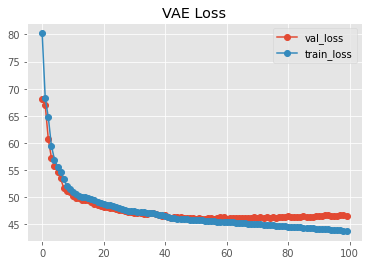

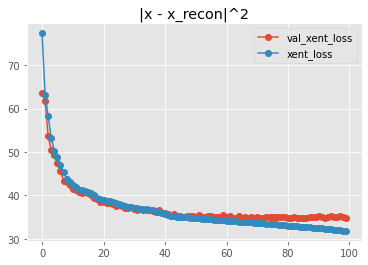

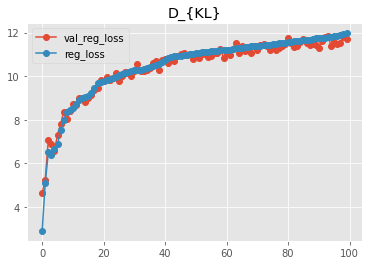

In [7]:
plt.style.use('ggplot')

val_loss = hist.history['val_loss']
loss = hist.history['loss']

val_xent_loss = hist.history['val_xent_loss']
xent_loss_hist = hist.history['xent_loss']

val_reg_loss = hist.history['val_reg_loss']
reg_loss_hist = hist.history['reg_loss']

plt.plot(val_loss, 'o-')
plt.plot(loss, 'o-')
plt.legend(['val_loss', 'train_loss'])
plt.title('VAE Loss')
plt.show()

plt.plot(val_xent_loss, 'o-')
plt.plot(xent_loss_hist, 'o-')
plt.legend(['val_xent_loss', 'xent_loss'])
plt.title('|x - x_recon|^2')
plt.show()

plt.plot(val_reg_loss, 'o-')
plt.plot(reg_loss_hist, 'o-')
plt.legend(['val_reg_loss', 'reg_loss'])
plt.title('D_{KL}')
plt.show()

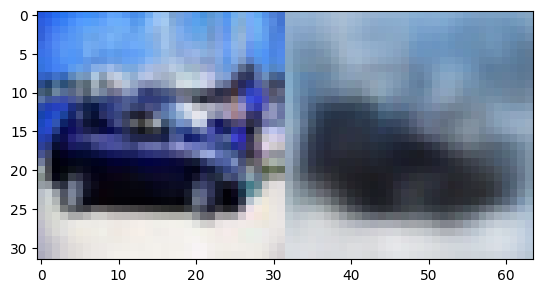

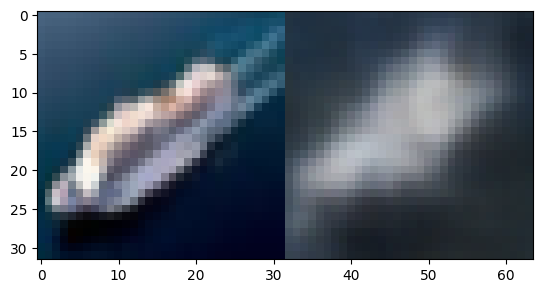

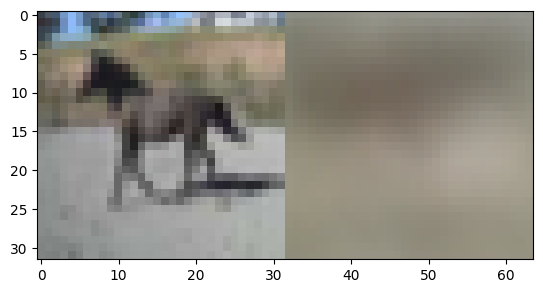

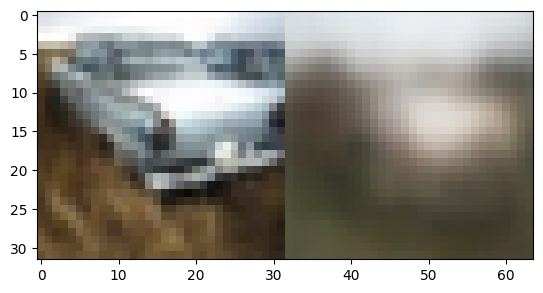

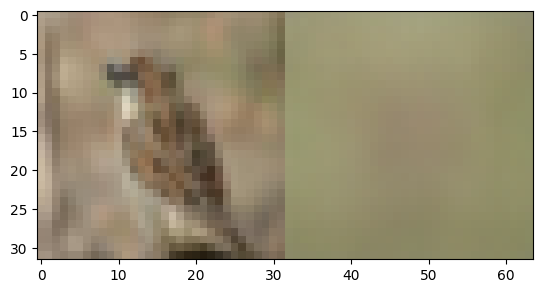

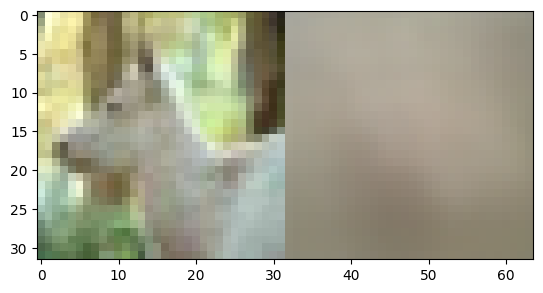

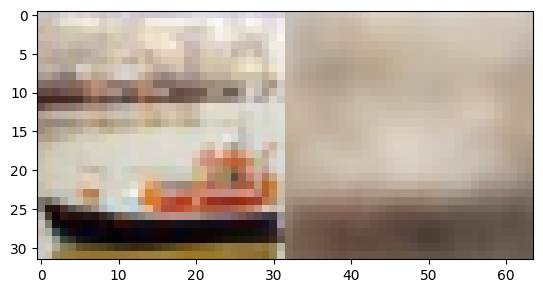

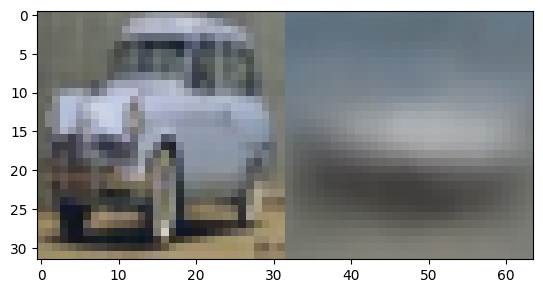

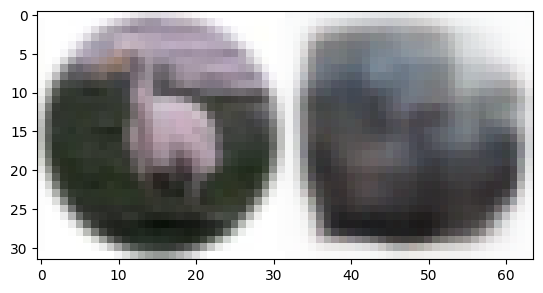

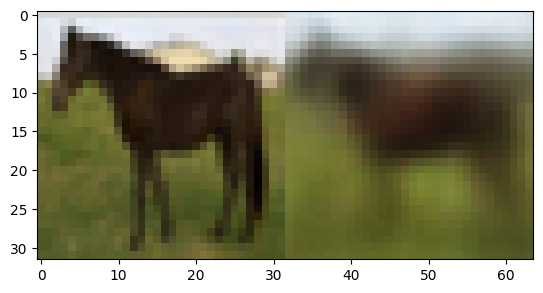

In [12]:
# RECONSTRUCTION
n = 100
digit_size = 32

sample = np.random.choice(np.array(range(len(x_test))), size=n)
x_sample = x_test[sample]

x_recon = vae.predict(x_sample, batch_size=batch_size)

plt.style.use('default')
for i in range(10):
    figure = np.zeros(shape=(digit_size, digit_size * 2, 3))

    figure[:, :digit_size, :] = x_sample[i]
    figure[:, digit_size:, :] = x_recon[i] 

    plt.imshow(figure)
    plt.show()   

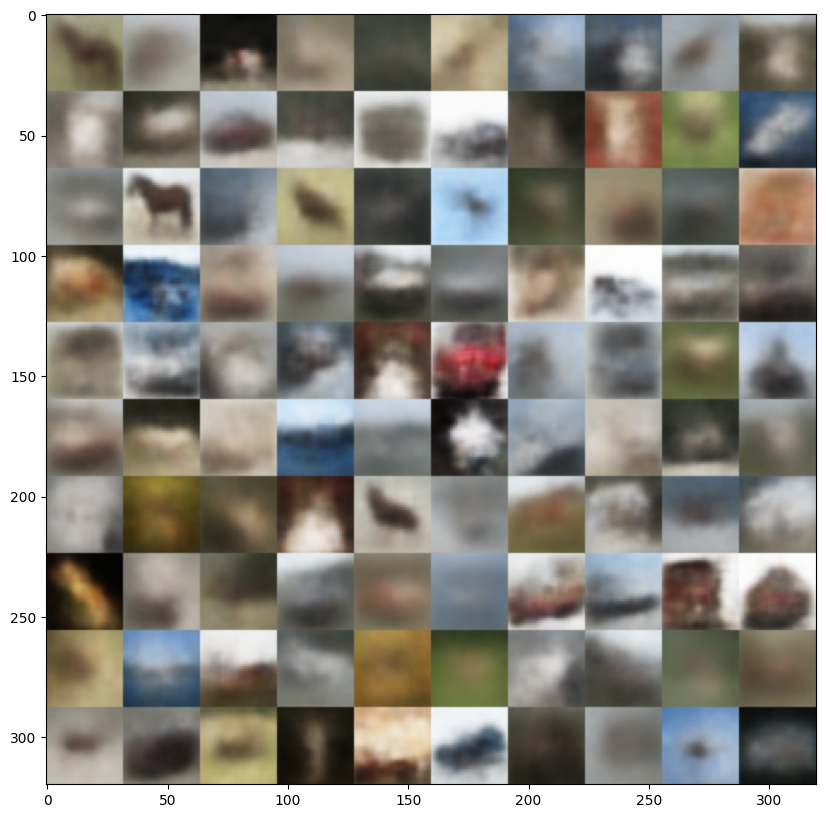

In [14]:
# GENERATE SAMPLES
n = 10 #figure with n x n digits
digit_size = 32

figure = np.zeros((digit_size * n, digit_size * n, 3))
# we will sample n points randomly sampled

z_sample = np.random.normal(size=(n ** 2, latent_dim), scale=1)
x_decoded = decoder.predict(z_sample)

for i in range(n):
    for j in range(n):
        figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size, :] = x_decoded[i + n * j]

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [13]:
# SAVE MODEL
from keras.models import save_model

vae.save('cifar_Naive_VAE_' + str(latent_dim) + '.h5')
encoder.save('encoder_cifar_Naive_VAE_' + str(latent_dim) + '.h5')
decoder.save('decoder_cifar_Naive_VAE_' + str(latent_dim) + '.h5')

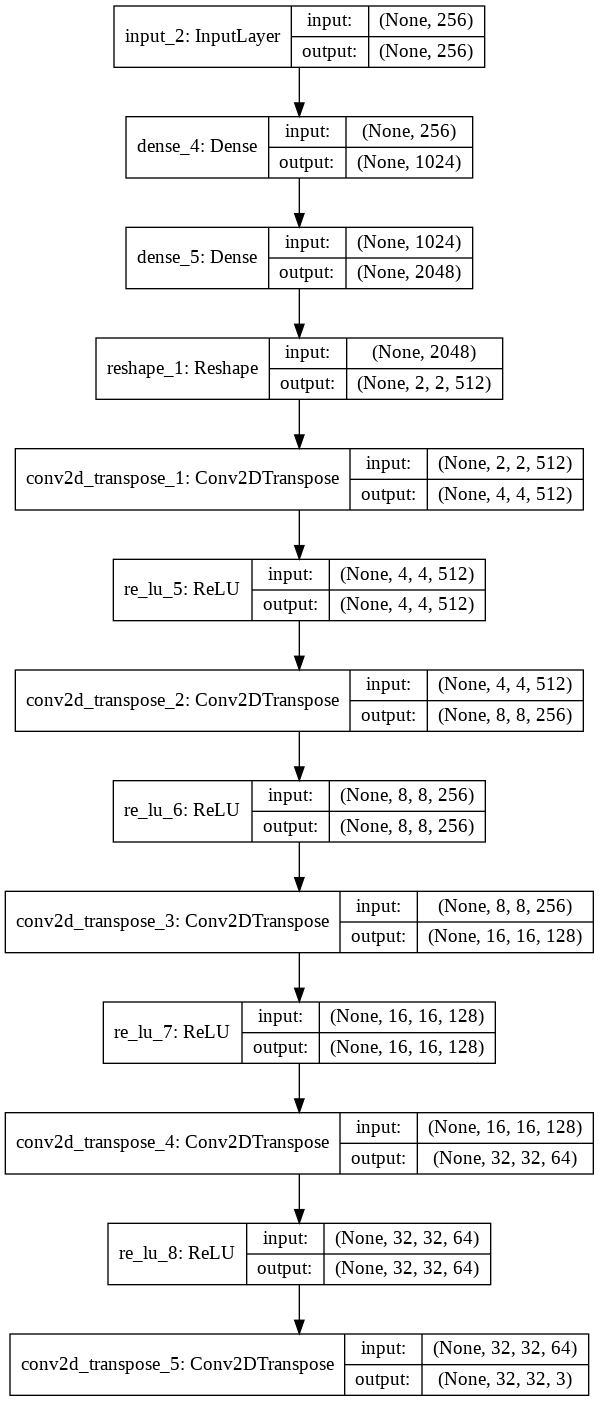

In [17]:
# PLOT MODEL
from keras.utils import plot_model
plot_model(vae, to_file='vae.png', show_shapes=True)
plot_model(encoder, to_file='encoder.png', show_shapes=True)
plot_model(decoder, to_file='decoder.png', show_shapes=True)